In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd  

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
RAW_DATA_PATH_X = '/Users/piyush/Desktop/dsml_Portfolio/visa/data/processed/X.csv'
RAW_DATA_PATH_y = '/Users/piyush/Desktop/dsml_Portfolio/visa/data/processed/y.csv'
X = pd.read_csv(RAW_DATA_PATH_X)
y = pd.read_csv(RAW_DATA_PATH_y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [5]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

#  grid search
grid_obj = GridSearchCV(xgb_model, parameters,scoring=scorer,cv=3)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [9]:
pickle.dump(xgb, open('/Users/piyush/Desktop/dsml_Portfolio/visa/models/model_XBG_Classifier.pkl', 'wb'))


In [6]:
def metrics_report(model,features,target):
    predictions = model.predict(features)
    acc = accuracy_score(target, predictions)  # to compute Accuracy
    recall = recall_score(target, predictions)  # to compute Recall
    precision = precision_score(target, predictions)  # to compute Precision
    f1 = f1_score(target, predictions)  # to compute F1-score

        # creating a dataframe of metrics
    df_metrics = pd.DataFrame({
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1 Score": f1,
            },index=[0],)

    return df_metrics

In [7]:
metrics_train = metrics_report(xgb,X_train,y_train)
metrics_test = metrics_report(xgb,X_test,y_test)

In [10]:
metrics_dataframe = pd.concat([metrics_train, metrics_test]).reset_index()

metrics_dataframe['index'] = ['train','test']
metrics_dataframe.set_index('index',inplace=True)

In [11]:
metrics_dataframe

,Accuracy,Recall,Precision,F1 Score
index,,,,
train,0.744835,0.921513,0.752281,0.828342
test,0.744859,0.922368,0.751958,0.828491


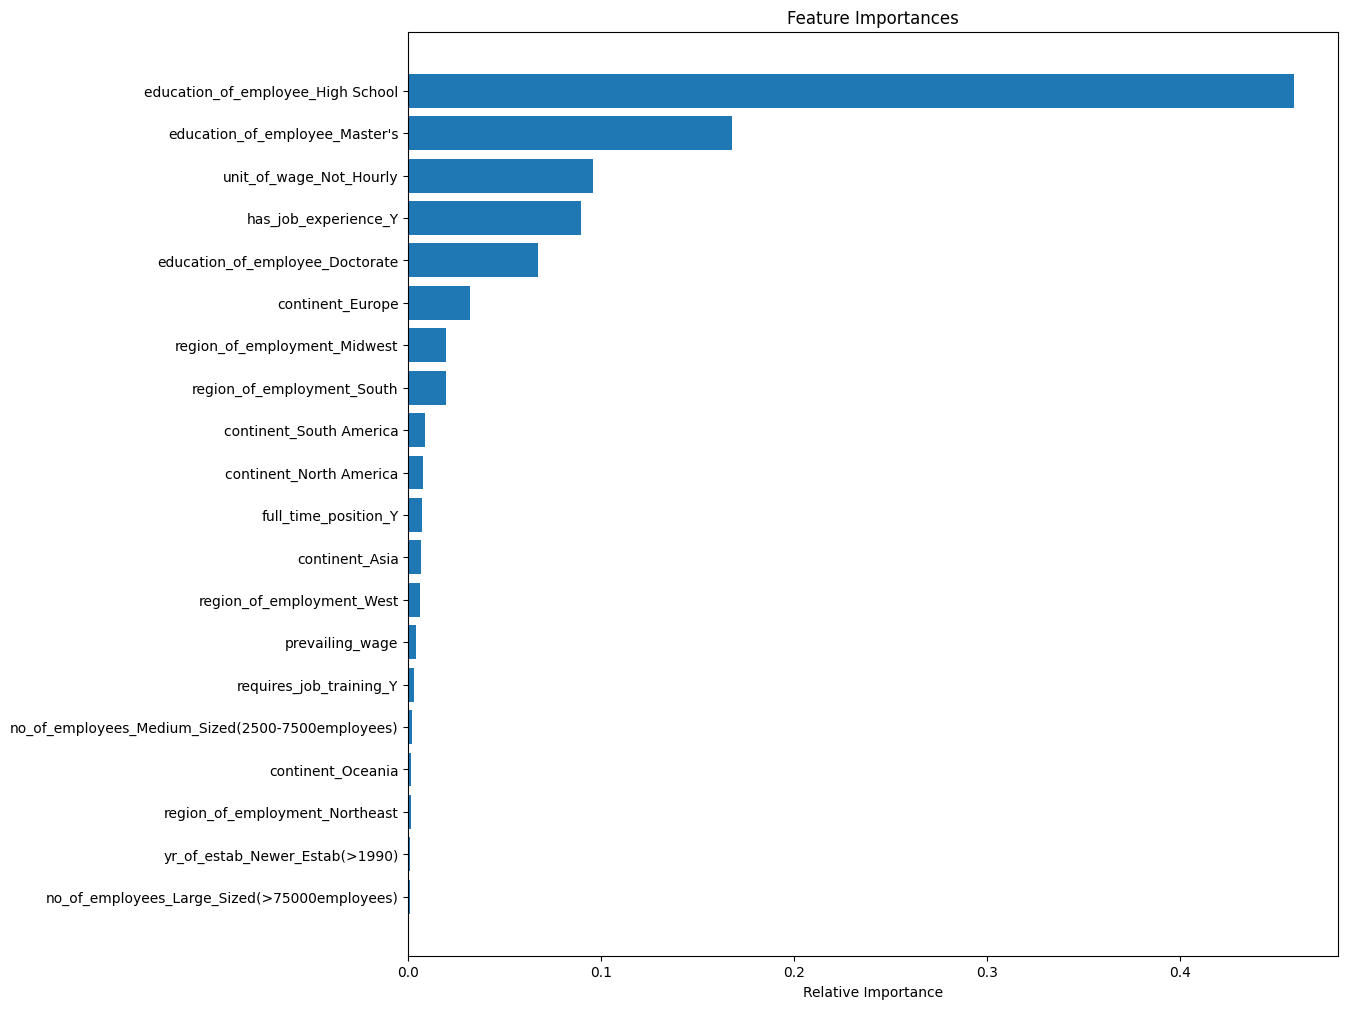

In [13]:
feature_names = X_train.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()